# Estratégias de Sampling para Modelos de Classificação Imbalanceados

Este notebook demonstra o uso de diferentes estratégias de sampling (Undersampling, SMOTE e Cost-Sensitive Learning) para lidar com datasets desbalanceados em problemas de classificação. Ele é projetado para ser um template, permitindo a fácil troca do modelo de classificação a ser avaliado.

**Modelo Inicial:** Regressão Logística
**Métricas de Avaliação:** F1-score, Precisão Média (Average Precision) e Curva Precision-Recall.

In [ ]:
# 1. Importar Bibliotecas Necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Baixar funções compartilhadas, se necessário
if not os.path.exists('shared_functions.py'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py',
        'shared_functions.py'
    )


# Baixar dados simulados, se necessário
if not os.path.exists('simulated-data-transformed'):
    os.system('git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed')

from shared_functions import *

%pip install graphviz

# Carregar funções compartilhadas e dados reais, conforme Anomaly.ipynb
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


## 2. Geração de Dados Sintéticos (Exemplo)

Para fins de demonstração, vamos gerar um dataset sintético desbalanceado. Em um cenário real, você carregaria seu próprio dataset.

In [ ]:


DIR_INPUT = 'simulated-data-transformed/data/'
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print(f"{len(transactions_df)} transactions loaded, containing {transactions_df.TX_FRAUD.sum()} fraudulent transactions")

output_feature = "TX_FRAUD"
input_features = [
    'TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
    'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
    'TERMINAL_ID_RISK_30DAY_WINDOW'
]

# Separar treino e teste conforme o handbook
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = 7
delta_delay = 7
delta_test = 7
delta_valid = delta_test
start_date_training_with_valid = start_date_training + datetime.timedelta(days=-(delta_delay+delta_valid))
train_df, valid_df = get_train_test_set(transactions_df, start_date_training_with_valid, delta_train=delta_train, delta_delay=delta_delay, delta_test=delta_test)

# Escalar os dados
train_df, valid_df = scaleData(train_df, valid_df, input_features)

X_train = train_df[input_features].values
X_test = valid_df[input_features].values
y_train = train_df[output_feature].values
y_test = valid_df[output_feature].values

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Distribuição das classes em y_train: {pd.Series(y_train).value_counts()}")

Load files
919767 transactions loaded, containing 8195 fraudulent transactions
Shape de X_train: (66928, 15)
Shape de y_train: (66928,)
Distribuição das classes em y_train: 0    66295
1      633
Name: count, dtype: int64


## 3. Função de Avaliação do Modelo

Esta função encapsula o treinamento e a avaliação do modelo, facilitando a comparação entre as diferentes estratégias de sampling. Ela aceita um modelo e, opcionalmente, um pipeline de pré-processamento/sampling.

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, strategy_name="Baseline"):
    """
    Treina e avalia um modelo de classificação usando as métricas especificadas.
    """
    print(f"\n--- Avaliando: {strategy_name} ---")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    f1 = f1_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_proba)

    print(f"F1-score: {f1:.4f}")
    print(f"Precisão Média (Average Precision): {avg_precision:.4f}")

    # Plotar Curva Precision-Recall
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name=strategy_name
    )
    _ = display.ax_.set_title(f"Curva Precision-Recall: {strategy_name}")
    plt.show()

    return {
        'strategy': strategy_name,
        'f1_score': f1,
        'average_precision': avg_precision
    }

## 4. Configuração do Modelo Base

Aqui definimos o modelo de classificação que será usado. Para este exemplo, começaremos com a Regressão Logística.

In [4]:
# --- TEMPLATE: Troque o modelo aqui ---
base_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' é bom para datasets pequenos e l1/l2 penalidades
# --------------------------------------

## 5. Avaliação das Estratégias de Sampling

### 5.1. Baseline (Sem Sampling)

Primeiro, avaliamos o modelo sem aplicar nenhuma estratégia de sampling para ter uma base de comparação.


--- Avaliando: Baseline ---
F1-score: 0.6065
Precisão Média (Average Precision): 0.5959


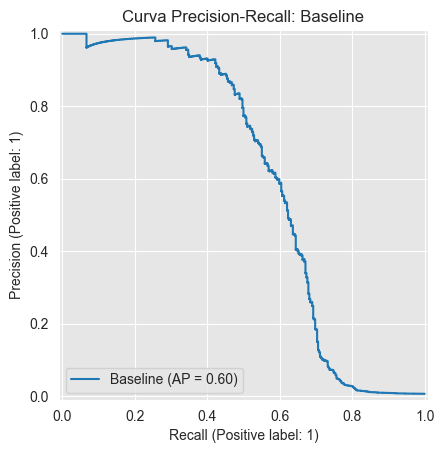

In [5]:
results = []
results.append(evaluate_model(base_model, X_train, y_train, X_test, y_test, strategy_name="Baseline"))

### 5.2. Undersampling (RandomUnderSampler)

Reduz o número de amostras da classe majoritária para balancear o dataset.


--- Avaliando: Undersampling ---
F1-score: 0.1841
Precisão Média (Average Precision): 0.4414


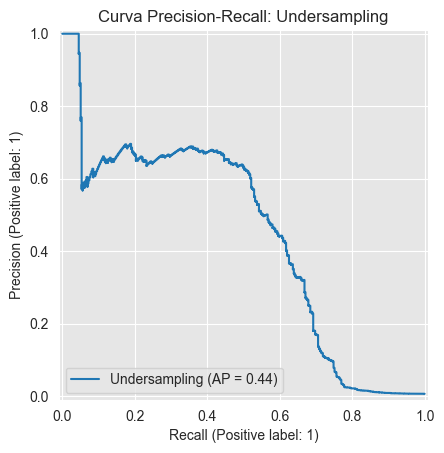

In [6]:
undersampler = RandomUnderSampler(random_state=42)
pipeline_undersample = Pipeline([('undersampler', undersampler), ('classifier', base_model)])

results.append(evaluate_model(pipeline_undersample, X_train, y_train, X_test, y_test, strategy_name="Undersampling"))

### 5.3. Oversampling (SMOTE)

Sintetiza novas amostras da classe minoritária para balancear o dataset.


--- Avaliando: SMOTE ---
F1-score: 0.1719
Precisão Média (Average Precision): 0.4682


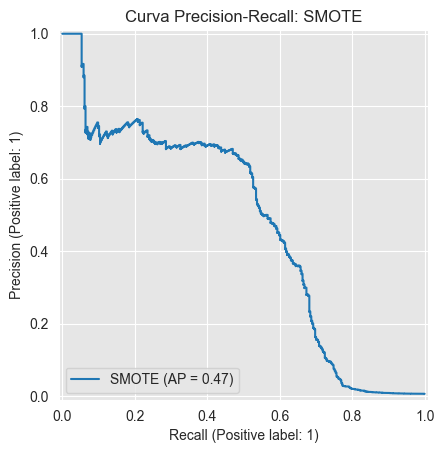

In [7]:
smote = SMOTE(random_state=42)
pipeline_smote = Pipeline([('smote', smote), ('classifier', base_model)])

results.append(evaluate_model(pipeline_smote, X_train, y_train, X_test, y_test, strategy_name="SMOTE"))

### 5.4. Cost-Sensitive Learning (Ajuste de `class_weight`)

Em vez de reamostrar os dados, esta abordagem atribui pesos diferentes às classes durante o treinamento, penalizando mais os erros na classe minoritária. Muitos modelos do scikit-learn (como `LogisticRegression`, `SVC`, `RandomForestClassifier`) possuem o parâmetro `class_weight`.


--- Avaliando: Cost-Sensitive ---
F1-score: 0.1833
Precisão Média (Average Precision): 0.4561


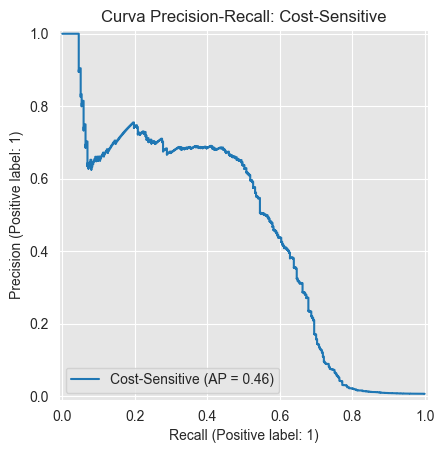

In [8]:
# Criar uma nova instância do modelo com class_weight='balanced'
cost_sensitive_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

results.append(evaluate_model(cost_sensitive_model, X_train, y_train, X_test, y_test, strategy_name="Cost-Sensitive"))

## 6. Comparação dos Resultados

Vamos consolidar e exibir os resultados de todas as estratégias para uma comparação fácil.


--- Comparação de Resultados ---
                f1_score  average_precision
strategy                                   
Baseline        0.606474           0.595880
Undersampling   0.184095           0.441388
SMOTE           0.171914           0.468163
Cost-Sensitive  0.183299           0.456095


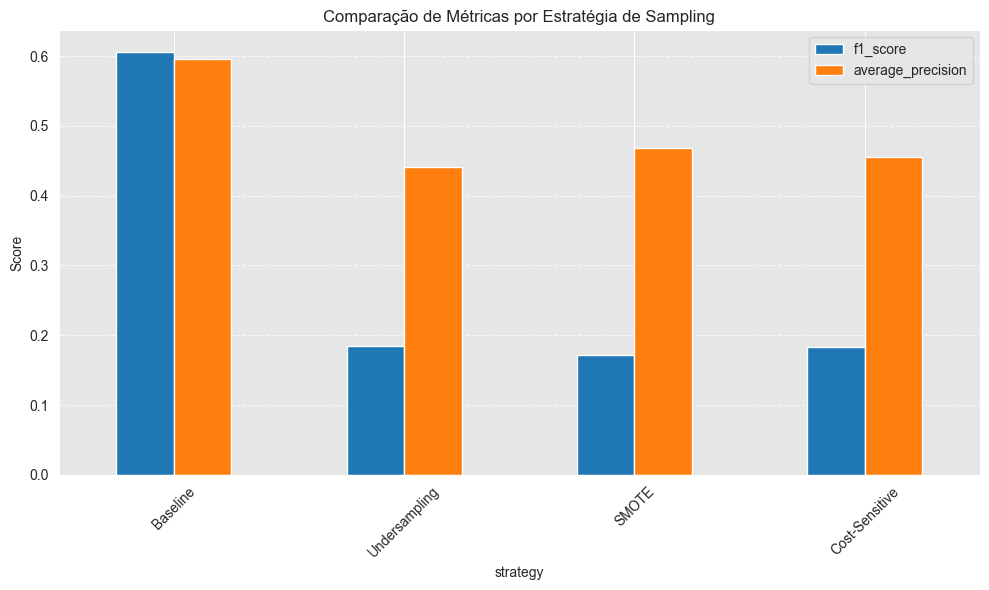

In [9]:
results_df = pd.DataFrame(results)
print("\n--- Comparação de Resultados ---")
print(results_df.set_index('strategy'))

# Opcional: Visualização dos resultados
results_df.set_index('strategy').plot(kind='bar', figsize=(10, 6))
plt.title('Comparação de Métricas por Estratégia de Sampling')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Como Trocar o Modelo

Para usar um modelo diferente (ex: `RandomForestClassifier`, `SVC`, `GradientBoostingClassifier`):

1.  **Importe o novo modelo** na seção de importações.
2.  **Modifique a variável `base_model`** na seção "Configuração do Modelo Base" para instanciar o novo modelo. Certifique-se de passar `random_state` se o modelo o suportar para reprodutibilidade.
    ```python
    # Exemplo para RandomForestClassifier
    from sklearn.ensemble import RandomForestClassifier
    base_model = RandomForestClassifier(random_state=42)
    ```
3.  **Para modelos que não suportam `class_weight`** (como alguns modelos baseados em árvores que não têm um `class_weight` direto no construtor, mas podem ter outras formas de lidar com desbalanceamento), você precisará ajustar a seção "Cost-Sensitive Learning" ou remover essa estratégia se não for aplicável.
4.  **Execute todas as células** novamente para ver os resultados com o novo modelo.